# The Capitial Asset Pricing Model for stock indices

**Importing and reading data** :

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt



df = pd.read_csv('stock data.csv', sep=';', decimal=',',thousands='.')
indexdf = pd.read_csv('stock data.csv', sep=';', decimal=',',thousands='.')


**Transforming data**:

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)

indexdf['Date'] = pd.to_datetime(indexdf['Date'], format='%d-%m-%Y')
indexdf = indexdf.sort_values(by='Date')
indexdf.set_index('Date', inplace=True)



**Visualizing the performance of the indices**

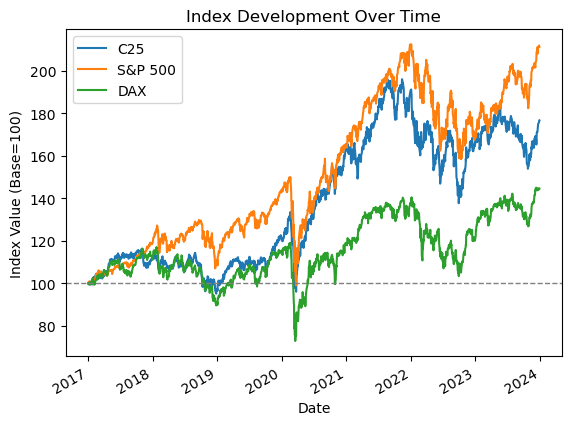

In [7]:

#To give an overview of the stock performance of each individual index, we relativize their performance starting from 100.
#Thus, for each column, every row is divided by the first row and multiplied by 100.
indexdf['C25 index=100'] = indexdf['c25'] / indexdf['c25'].iloc[0]*100
indexdf['SP500 index=100'] = indexdf['sp500'] / indexdf['sp500'].iloc[0]*100
indexdf['DAX index=100'] = indexdf['dax'] / indexdf['dax'].iloc[0]*100



#Plotting
plt.plot(indexdf.index, indexdf['C25 index=100'], label='C25', linewidth=1.5)
plt.plot(indexdf.index, indexdf['SP500 index=100'], label='S&P 500', linewidth=1.5)
plt.plot(indexdf.index, indexdf['DAX index=100'], label='DAX', linewidth=1.5)
plt.axhline(y=100, color='grey', linestyle='--', linewidth=1)


plt.xlabel('Date')
plt.ylabel('Index Value (Base=100)')
plt.title('Index Development Over Time')

plt.legend()


plt.gcf().autofmt_xdate()
plt.show()



The above shows that, in the period, S&P has performed the best, C25 second and the German DAX index the worst.

**Anuualizing and providing overview of covariance, variance and returns**

In [8]:
#annualization 

df = df.pct_change() #Calculating the daily return
period = ((df.index.max() - df.index.min()).days)/365.25 #Here, we obtain (as a yearly fraction) the total period for our data
total_trading_days = df.shape[0] #Here we extract the number of rows which corresponds to the number of trading days.
trading_days_pr_year = total_trading_days/period #Using the above, we can calculate the average trading days count per year, so that we can annualize our results that is based on daily data.



#mean values
mean_c25_annualized = (1+df['c25'].mean())**trading_days_pr_year -1
mean_sp500_annualized = (1+df['sp500'].mean())**trading_days_pr_year -1
mean_dax_annualized = (1+df['dax'].mean())**trading_days_pr_year -1


#covariance matrix

covariance_matrix = df.cov()*trading_days_pr_year

C25_STD = np.sqrt(covariance_matrix.iloc[0,0])
SP500_STD = np.sqrt(covariance_matrix.iloc[1,1])
DAX_STD = np.sqrt(covariance_matrix.iloc[2,2])

overview_table = {
    'Index': ['C25', 'SP500', 'DAX'],
    'Exp. return': [mean_c25_annualized, mean_sp500_annualized, mean_dax_annualized],
    'Volatility': [C25_STD, SP500_STD, DAX_STD]
}

temp_table = pd.DataFrame(overview_table)
print('Variance/Covariance matrix:')
print(covariance_matrix)
print('')
print(temp_table.to_string(index = False))

Variance/Covariance matrix:
            c25     sp500       dax
c25    0.029855  0.014422  0.021489
sp500  0.014422  0.036935  0.021911
dax    0.021489  0.021911  0.036753

Index  Exp. return  Volatility
  C25     0.101297    0.172787
SP500     0.133931    0.192185
  DAX     0.073883    0.191710


**Calculating minimum variance portfolio, efficient tangent portfolio and sharpe ratio**:

In [9]:



return_vector = np.array([mean_c25_annualized, mean_sp500_annualized, mean_dax_annualized])

risk_free_rate_annualized = 0.05 #Defining the riskfree rate.

#minimum variance portfolio 

#Calculating z-matrix

covariance_matrix_inverted = np.linalg.inv(covariance_matrix)
one_vector = np.ones((len(covariance_matrix),1))
z_vector_minvar = covariance_matrix_inverted.dot(one_vector)


#calculating weights for minimums variance portfolio
x_vector_minvar = (1/np.sum(z_vector_minvar))*z_vector_minvar

#expected return for minimum variance portfolio
exp_return_minvar = return_vector.dot(x_vector_minvar)

#Standard deviation for min variance portfolio
variance_minvar = np.transpose(x_vector_minvar).dot(covariance_matrix).dot(x_vector_minvar)

std_minvar = np.sqrt(variance_minvar)

#Efficient tangent portfolio
#Excess return 
excess_return_vector = return_vector - risk_free_rate_annualized

z_vector_efftan = covariance_matrix_inverted.dot(excess_return_vector)

#calculating weights for efficient tangent portfolio
x_vector_efftan = (1/np.sum(z_vector_efftan))*z_vector_efftan

#expected return for efficient tangent portfolio
exp_return_efftan = return_vector.dot(x_vector_efftan)

#Standard deviation for efficient tangent portfolio
variance_efftan = np.transpose(x_vector_efftan).dot(covariance_matrix).dot(x_vector_efftan)
std_efftan = np.sqrt(variance_efftan)


x_vector_minvar = np.transpose(x_vector_minvar)

Sharpe = ((exp_return_efftan - risk_free_rate_annualized)/std_efftan)

overview_table2 = {
    'Portfolio': ['Min var', 'Eff. tangent'],
    'Exp. return': [exp_return_minvar[0], exp_return_efftan],
    'Volatility': [std_minvar[0][0], std_efftan]
}

temp_table2 = pd.DataFrame(overview_table2)
print(temp_table2.to_string(index = False))

print('')

overview_table3 = {
    'Eff.Tan Portfolio': ['C25', 'SP500','DAX'],
    'Weights(%)': [x_vector_efftan[0]*100, x_vector_efftan[1]*100, x_vector_efftan[2]*100]
    
}

temp_table3 = pd.DataFrame(overview_table3)
print(temp_table3.to_string(index = False))

   Portfolio  Exp. return  Volatility
     Min var     0.109941    0.152847
Eff. tangent     0.159501    0.206588

Eff.Tan Portfolio  Weights(%)
              C25   74.019178
            SP500  108.790354
              DAX  -82.809532


Now, since we have two portfolios that both lie on the efficient frontier, we can recreate the whole one by using the Two-Mutual-Fund Theorem, which states that the rest can be replicated by linear combinations of the first two. Thus, in the following we define weights between -10 and 10 (corresponding to going, respectively, 1000% short and 1000% long in the first asset and - contrary 1-w in the second), use these to calculate exp. return and volatility for these resulting portfolios. Lastly, these are scattered in a plot together (resulting in the parabolic curve called the efficient frontier) with the capital market line which - according to theory - should tangentize the efficient tanget portfolio. In this case the risk-free rate is chosen to be 5\%.

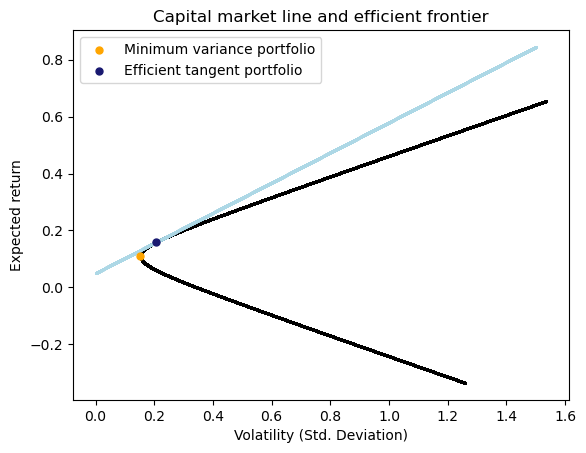

In [10]:
Two_mutual_fund_range = np.linspace(-10,10,100000)
return_list = []
volatility_list = []

for weight in Two_mutual_fund_range:
    minvar_weight = weight
    efftan_weight = 1 - minvar_weight
    portfolio_weight = minvar_weight*x_vector_minvar + efftan_weight*x_vector_efftan
    exp_return = portfolio_weight.dot(np.transpose(return_vector))
    var = portfolio_weight.dot(covariance_matrix).dot(np.transpose(portfolio_weight))
    std = np.sqrt(var)
    return_list.append(exp_return)
    volatility_list.append(std)

x_values = np.linspace(0,1.5,100000)
Capital_market_line = risk_free_rate_annualized+Sharpe*x_values


plt.scatter(volatility_list, return_list, s=1, color='black')
plt.scatter(x_values, Capital_market_line, color='lightblue', zorder=5, s=0.1)
plt.scatter(std_minvar, exp_return_minvar, color='orange', label='Minimum variance portfolio', zorder=5, s=25)
plt.scatter(std_efftan, exp_return_efftan, color='midnightblue', label='Efficient tangent portfolio', zorder=5, s=25)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected return')
plt.title('Capital market line and efficient frontier')

plt.legend()
plt.show()



Lastly, we utilize the widget library to make the CAPM figure interactive for different risk-free rates.

In [11]:
from ipywidgets import interactive, FloatSlider
import matplotlib.pyplot as plt


def plot_efficient_frontier(risk_free_rate_annualized):
    excess_return_vector = return_vector - risk_free_rate_annualized
    z_vector_efftan = covariance_matrix_inverted.dot(excess_return_vector)
    x_vector_efftan = (1/np.sum(z_vector_efftan))*z_vector_efftan
    exp_return_efftan = return_vector.dot(x_vector_efftan)
    variance_efftan = np.transpose(x_vector_efftan).dot(covariance_matrix).dot(x_vector_efftan)
    std_efftan = np.sqrt(variance_efftan)
    Sharpe = (exp_return_efftan - risk_free_rate_annualized) / std_efftan
    
    # Plot code as before, using the updated 'risk_free_rate_annualized' and other calculations
    x_values = np.linspace(0,1.5,100000)
    Capital_market_line = risk_free_rate_annualized + Sharpe * x_values

    plt.figure(figsize=(12, 8))
    plt.scatter(volatility_list, return_list, s=1, color='black')
    plt.scatter(x_values, Capital_market_line, color='lightblue', zorder=5, s=0.1)
    plt.scatter(std_minvar, exp_return_minvar, color='orange', label='Minimum variance portfolio', zorder=5, s=25)
    plt.scatter(std_efftan, exp_return_efftan, color='midnightblue', label='Efficient tangent portfolio', zorder=5, s=25)
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected return')
    plt.title('Capital market line and efficient frontier')
    plt.legend()
    plt.show()

# Create an interactive slider for 'risk_free_rate_annualized'
# Run this part in an IPython environment to see the interactive widget

# Define the slider with a custom label
risk_free_rate_slider = FloatSlider(
    value=0.05,  # starting value of slider
    min=0,       # minimum value
    max=exp_return_minvar,     # maximum value
    step=0.005,  # step size
    description='Risk-Free Rate:',  # label for the slider
    style={'description_width': 'initial'},  # make sure the description isn't cut off
    continuous_update=False  # update the plot only when the slider is released
)

# Create the interactive plot
interactive_plot = interactive(
    plot_efficient_frontier,
    risk_free_rate_annualized=risk_free_rate_slider
)

# Set the height of the output plot area
output = interactive_plot.children[-1]
output.layout.height = '500px'

# Display the interactive plot
interactive_plot

interactive(children=(FloatSlider(value=0.05, continuous_update=False, description='Risk-Free Rate:', max=0.10…

# Conclusion

We have now used the CAPM model to create the efficient tangent portfolio and the minimum variance portfolio from the 3 index C25, SP500 and DAX. 